In [8]:
import torch 
import matplotlib.pyplot as plt
from fmfts.experiments.ks2d.models import VelocityModelKS2D
from fmfts.dataloader.ks2d import DatasetKS2D
import fmfts.experiments.ks2d.training_parameters as params
params = params.TrainingParameters()

torch.set_grad_enabled(False)
torch.set_default_device("cuda")

velocity = VelocityModelKS2D(features = params.features_velocity)
velocity.load_state_dict(torch.load("trained_models/state_velocity.pt", weights_only=True)["model"])
dataset_test = DatasetKS2D(mode = "test")

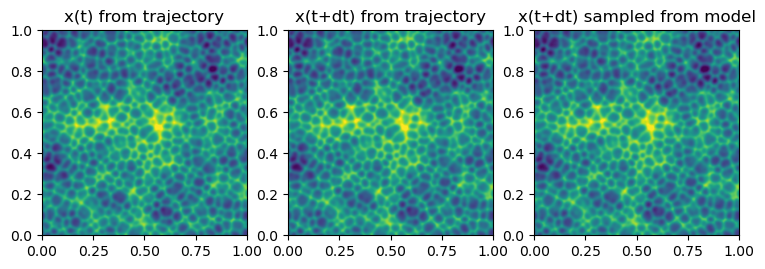

In [9]:
# demonstrates how one can predict a single sample
y, x = dataset_test[0]
y, x = y.unsqueeze(0), x.unsqueeze(0)
x_pred = velocity.sample(y, steps=2, method="euler")

# plotting
fig, ax = plt.subplots(1, 3, figsize=(3*3, 3))
dataset_test.plot(y, ax[0])
dataset_test.plot(x, ax[1])
dataset_test.plot(x_pred, ax[2])
ax[0].set_title("x(t) from trajectory")
ax[1].set_title("x(t+dt) from trajectory")
ax[2].set_title("x(t+dt) sampled from model")
plt.show()

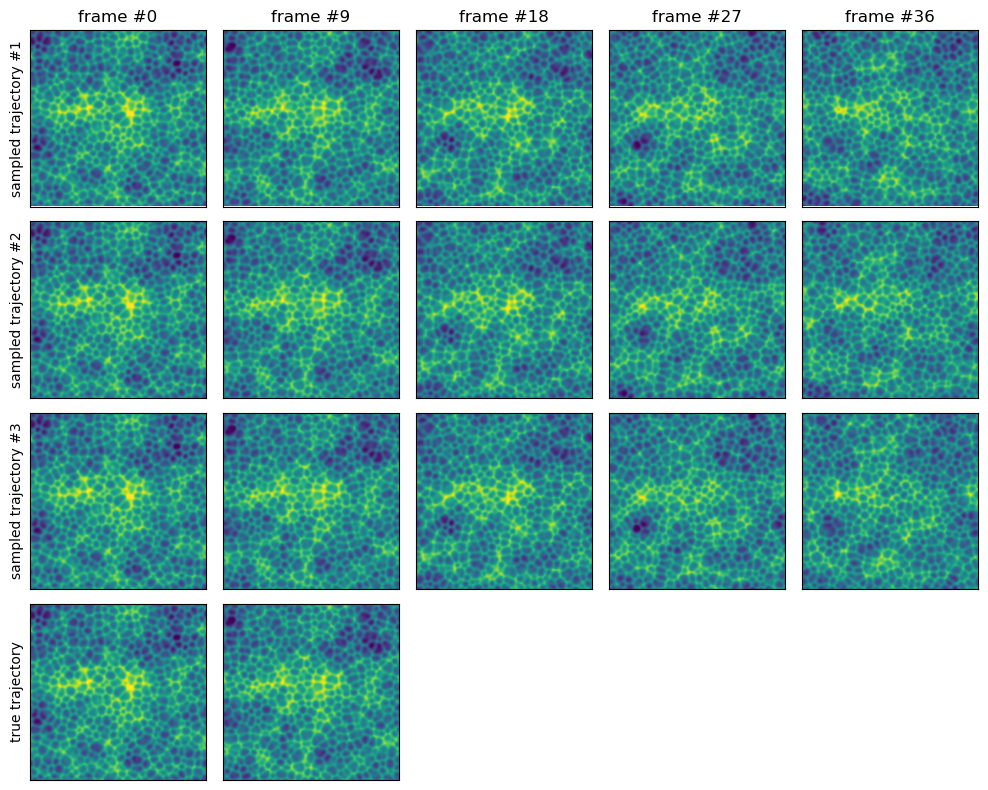

In [14]:
# demonstrates how one can generate multiple trajectories
n_trajectories = 3
n_predictions = 45
y, _ = dataset_test[0]
xs = torch.empty(n_predictions, n_trajectories, *y.shape)
xs[:,:] = y.clone()
for k in range(n_predictions-1):
    xs[k+1] = velocity.sample(xs[k], steps=4, method="euler") 

# plotting
n_plots   = 5

fig, ax = plt.subplots(n_trajectories + 1, n_plots, figsize=(n_plots*2, (n_trajectories+1)*2))
for k in range(n_trajectories):
    for i in range(n_plots):
        l = i * n_predictions // n_plots
        dataset_test.plot(xs[l, k], ax[k, i])
        ax[k, i].set_xticks([])
        ax[k, i].set_yticks([])
    ax[k,0].set_ylabel(f"sampled trajectory #{k+1}")

for i in range(n_plots):
    l = i * n_predictions // n_plots
    if l < len(dataset_test.data): 
        dataset_test.plot(dataset_test.data[l], ax[-1, i])
        ax[-1, i].set_xticks([])
        ax[-1, i].set_yticks([])
    else:                          
        ax[-1, i].remove()

    ax[0, i].set_title(f"frame #{l}")
ax[-1, 0].set_ylabel("true trajectory")

plt.tight_layout()
plt.show()